### Script de modelagem direta da bacia de barreirinhas - dados grav adquiridos por Nelson Delimar

In [1]:
# importando pacotes necessarios:
import numpy as np # pacote numerico
import pylab as py 
#from numpy.linalg import inv # pacote de algebra linear
import matplotlib.pyplot as plt # pacote de plotagem
#import pandas as pd # pacode de tratamento de dados 
#from mpl_toolkits.basemap import Basemap
#from matplotlib.patches import Polygon
#from scipy.interpolate import Rbf # radial basis functions technique
#para plotar as figuras nas celulas do jupyter notebook:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
#%matplotlib inline
%matplotlib tk
#plt.plot ([1,2])

### Importando os pacotes com as nossas funcoes:

In [2]:
from modules.iplots import pick_points # para fazer o plot interativo
from modules.gravity import grav2D_anom # funcao que calcula dados de gravidade (rao 1994)

### Leitura dos dados reais do perfil de Barreirinhas:

In [3]:
# leitura no script do pc do bijani:
#x_utm, y_utm, elev, gz = np.loadtxt('../../dados_reais/Barreirinhas/barreirinhas_perfil.txt', skiprows=1 , usecols = (0,1,2,3), unpack = True)
elev, gz, x_utm, y_utm = np.loadtxt('../dados_reais/Barreirinhas/barreirinhas_perfil.txt', 
                                    skiprows=1 , usecols = (2,3,0,1), unpack = True)

# leitura no script no pc do mathews:
#x_utm, y_utm, elev, gz = np.loadtxt('../dados_reais/barreirinhas_perfil.txt', skiprows=1 , usecols = (0,1,2,3), unpack = True)

#alterando o sinal de elev devido a mudança da referencia do eixo z (positivo para baixo):
elev = -elev                                   

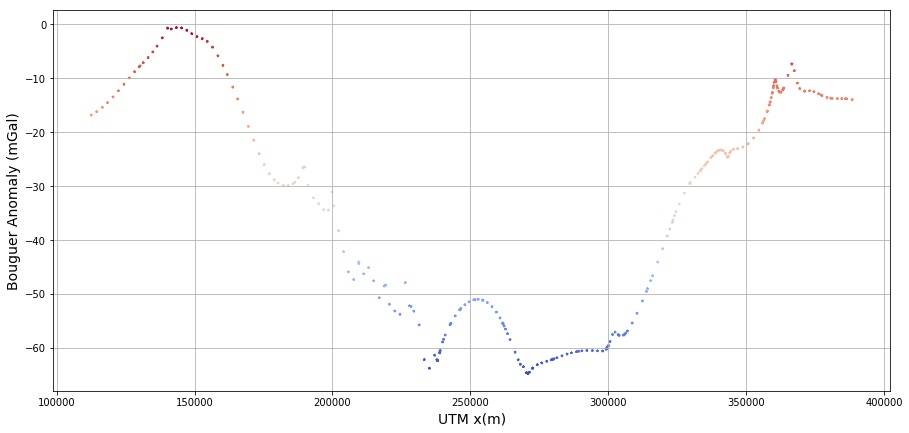

In [4]:
# Plot dos dados para verificação:
plt.figure(figsize=(15,7), facecolor='w')

plt.scatter(x_utm,gz,s=5.0,c=gz,marker='*', cmap=plt.cm.coolwarm)
#plt.plot(x_utm, gz,'*r')
#plt.title ('Gravity Data (mGal)', fontsize = 16)
plt.xlabel ('UTM x(m)', fontsize = 14)
plt.ylabel ('Bouguer Anomaly (mGal)', fontsize = 14)
plt.grid()
#plt.savefig('Bouguer.png', dpi=300, transparent=True, bbox_inches="tight" )
plt.show()

### Definicao da area de plot do modelo:

In [5]:
area= []
xmin = np.min(x_utm)
xmax = np.max(x_utm)
zmin = np.min( (elev) ) #-100.0
#zmax = 3.0 #profundidade da bacia em km (entradas do rao et al., 1994 em Km)
zmax = 2500.0 #adaptado para metros !
print(zmin)
area = [xmin, xmax, zmin, zmax]
print(area)

-63.5875444644
[112524.41296161991, 388476.30243990006, -63.587544464414314, 2500.0]


### Criacao do modelo de bacia atraves dos clicks na area de plot: 

In [6]:
%matplotlib tk 
axes = plt.figure().add_subplot(1,1,1)
xv,zv = pick_points(area, axes, marker='o', color='k', size=8, xy2ne=False)

### calculo da anomalia de gravidade produzido pelo modelo de bacia (artigo do Rao et. al., 1994):

In [7]:
# info da propriedade fisica:
delta_rho = -1.40 #(g/cm³)# contraste de Densidade do arenito em relacao ao embasamento local no topo da bacia!
beta = 10.12
# convertendo para SI(kg/m³):
rho_ref = 3.0 # densidade do embasamento (checar!)
rho = delta_rho + rho_ref
#rho = rho * 1000.0 
print('densidade no topo da bacia em g/cm³=', rho)

densidade no topo da bacia em g/cm³= 1.6


In [8]:
#Criacao de variaveis necessarias para o calculo da anomalia:
nv = np.size (xv)
#print nv
nper = np.size (x_utm)
#print nper
# calculo da anomalia grav atraves de rao1994:
xd = np.zeros( (nv,) )
zd = np.zeros( (nv,) )
grav = np.zeros( (nper,) )
for i in range(nper):
    for j in range(nv):
        xd[j] = ( xv[j] - x_utm[i])/1000.0
        zd[j] = (zv[j]- elev[i])/1000.0
    # chamando a funcao do rao 1994:
    grav[i] = grav2D_anom(xd,zd,delta_rho,beta)

In [17]:
#######################################################
# computing hyperbolic density function
########################################################
z = np.linspace( np.amin(zv), np.amax(zv), np.size(zv) ) # em km
rhoz = np.zeros( np.size(z) )
rhoz[0] = delta_rho
rhoz[1:] = (delta_rho)*beta**2/(beta + (z[1:]/100.0) )**2 # conversao para g/cm3 (CORRETO!!!!)
#rhoz = rhoz + 2.670

In [20]:
# plot of the density distribution:
fig = plt.figure(figsize=(7,7))

# definition of fontsize:
fs = 15 
# invert axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# set labelsize 
plt.tick_params(axis='y', labelsize=fs-2)
plt.tick_params(axis='x', labelsize=fs-2,labelbottom=True,labeltop=True)

plt.text(rhoz[0]+0.01, z[0]+0.148, str( format(rhoz[0],'.3f') ), style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

plt.plot(rhoz,z,'k-',linewidth=2.0)
plt.plot(rhoz[0],z[0],'ro',linewidth=2.0)
plt.grid()
plt.xlabel(r'Density contrast $(g/cm^3)$',fontsize=fs)
plt.ylabel(r'Depth $(km)$',fontsize=fs)
plt.axis([np.max(rhoz)+0.05, np.min(rhoz)-0.02, np.max(z)+0.1, np.min(z)-0.1])
plt.savefig('density.png', dpi=300, transparent=True, bbox_inches="tight" )
plt.show()
#############################################################################################################

In [22]:
# get the number of elements of xv (number of vertices of the polygon)
n = np.size(xv)     
# create new working arrays for the vertices of a closed polygon:
x = np.zeros( (n+1,) )  
z = np.zeros( (n+1,) ) 
x[0:n] = xv
z[0:n] = zv
# GAMBIARRA PARA PLOT DE CORES ASSSOCIADOOS À BACIA MODELADA (PENSAR EM ALGO MILHÓ) 
x[n:n+1] = min(xv)
z[n:n+1] = np.min(zv)

In [24]:
# and the modeled basin:
fig = plt.figure(figsize=(14,8))
path = Path(np.array([x,z]).T)
patch = PathPatch(path, facecolor='none')

#######################################################
plt.gca().add_patch(patch)
plt.plot(xv,zv,'k-o')

# plot the last and the first corner to close up the polygon:
fs = 18 # font size for the label
plt.gca().invert_yaxis()
plt.xlabel(r'UTM x $(m)$',fontsize=fs)
plt.ylabel(r'Depth $(m)$',fontsize=fs)
plt.xlim([np.min(xv), np.max(xv)])

##################################################################
# plot the density variation together with the basin:
##################################################################

im = plt.imshow(rhoz.reshape(np.size(zv),1),  cmap=plt.cm.Wistia,interpolation="bicubic",
                origin='lower',extent=[min(x), max(x), min(z), max(z)],aspect="auto", clip_path=patch, clip_on=True)
#im.set_clip_path(patch)

# OBS:::::: para reverter a escala de cores, basta um simples "_r" ! sucesso de vida!!!!
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'Density constrast in $g/cm^3$', fontsize=fs)

# Mat, verificar!!!!!!
plt.savefig("basin01.png", dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### Plot do modelo atual + os dados reais para comparação:

In [27]:
plt.plot(x_utm,gz,'.k', label='observed data')
plt.plot(x_utm,grav,'.r', label='predicted data')
plt.legend()
plt.grid()
#plt.title ('Gravity Data (mGal)', fontsize = 16)
plt.xlabel ('UTM x(m)', fontsize = 14)
plt.ylabel ('Bouguer Anomaly (mGal)', fontsize = 14)
plt.savefig('Datafit.png', dpi=300)
plt.show()

# Criacao de um branch para nao perder clicks promissores!!!!!!

In [ ]:
## criacao do branch --- variaveis guardadas para nao perder cliques promissores!
### SOMENTE RODAR ESSA CELULA EM CASO DE MELHORIAS SIGNFICATIVAS NOS CLICKS!!!!
x_branch = np.copy(xv)
y_branch = np.copy(zv)
gz_branch = np.copy(grav)

### TODO:: Gerar um arquivo com as variaveis branch para backup de clicks promissoes!

In [ ]:
# ---- comparacao entre o dado branch vs o ultimo click-----:
plt.plot(x_utm, grav,'.k', label='observed data')
plt.plot(x_utm, gz_branch,'.m', label='branch data')
plt.legend()
plt.grid()
plt.title ('Gravity Data (mGal)', fontsize = 16)
plt.xlabel ('UTM x(m)', fontsize = 14)
plt.ylabel ('Gravity Anomaly (mGal)', fontsize = 14)
plt.show()